In [1]:
import json
import sys, os

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/stylegan2'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/gan/'))

from typing import List
import numpy as np
import albumentations
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
from albumentations.pytorch import ToTensorV2
#from albumentations.torch import ToTensor as ToTensorV2
from torch import Tensor, nn
from torch import optim
from dataset.cardio_dataset import SegmentationDataset
from dataset.lazy_loader import LazyLoader
from dataset.probmeasure import ProbabilityMeasureFabric, ProbabilityMeasure
from dataset.toheatmap import heatmap_to_measure
from loss.losses import Samples_Loss
from modules.hg import HG_softmax2020
from parameters.path import Paths

In [2]:
from torchvision.datasets import CelebA
from dataset.toheatmap import ToHeatMap
# from dataset.MAFL import MAFLDataset
# from transforms_utils.transforms import MeasureToMask, ToNumpy, NumpyBatch, ToTensor, MaskToMeasure, ResizeMask, \
#     NormalizeMask, ParTr

In [3]:
def center_by_face(image: torch.Tensor, landmarks: torch.Tensor):
    image, landmarks = np.transpose(image.numpy(), (1,2,0)), landmarks.numpy()
    # y_center = int(landmarks[36][0] + landmarks[45][0]) // 2
    # x_center = int(landmarks[:,1].mean().item())
    y, x = landmarks[:,0], landmarks[:,1]
    keypoints_landmarks = [x, y, 0, 1]
    # H, W, C = image.shape
    # W_max = min(x_center, W - x_center)
    # H_max = min(y_center, H - y_center)
    # radius = min(W_max, H_max)
    # y_max, y_min = min(H, y_center + H//2), max(0, y_center - H//2)
    # x_max, x_min = min(W, x_center + W//2), max(0, x_center - W//2)
    H, W, C = image.shape
    H09 = int(H * 0.9)
    rh = max(int(270 * H09 / W), 270)
    rw = max(int(270 * W / H09), 270)
    transforms = albumentations.Compose([
        albumentations.Crop(x_min=0, y_min=0, x_max=W, y_max=H09),
        albumentations.Resize(rh, rw),
        albumentations.CenterCrop(256, 256)
    ])
    data_dict = transforms(image=image, keypoints=[keypoints_landmarks])
    image_new = torch.tensor(np.transpose(data_dict['image'], (2,0,1)))
    kp_x, kp_y = data_dict['keypoints'][0][0], data_dict['keypoints'][0][1]
    keypoints_new = torch.cat([torch.tensor(kp_x)[..., None], torch.tensor(kp_y)[..., None]], dim=1)
    return image_new, keypoints_new

def kp_normalize(H, W, kp):
    kp = kp.clone()
    kp[..., 0] = kp[..., 0] / (W-1)
    kp[..., 1] = kp[..., 1] / (H-1)
    return kp

In [4]:
class OurCeleba(CelebA):
    def _check_integrity(self):
        return True
    
    def __getitem__(self, index):
        data, kp = super().__getitem__(index)
        data = torch.from_numpy(np.asarray(data)).permute(2,0,1)
        kp = torch.tensor([(kp[i].item(), kp[i+1].item()) for i in range(0,len(kp),2)])
        
        data, kp = center_by_face(data, kp[:, [1, 0]]) # kp[:, [0, 1]])
        C, H, W = data.shape
        meta = {'keypts': kp, 'keypts_normalized': kp_normalize(W, H, kp), 'index': index}

        return {"data": data, "meta": meta}


In [5]:
celeba_dataset = OurCeleba("/raid/data/", target_type="landmarks", download=False, split='train')

In [7]:
celeba_dataset[0]['data'].shape

torch.Size([3, 256, 256])

In [6]:
w300_dataset = LazyLoader.w300()

300 W initialize
train size: 3148, test size: 689


In [7]:
q = next(w300_dataset.loader_train_inf) 

In [8]:
q.keys()
q['data'].shape

torch.Size([8, 3, 256, 256])

In [27]:
q['data'].min()

tensor(-1.)

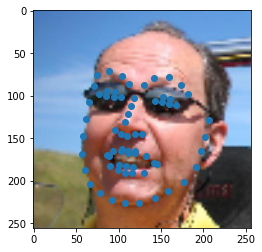

In [9]:
i = 2
plt.scatter(q['meta']['keypts'][i][:,0], \
            q['meta']['keypts'][i][:,1])
plt.imshow(((q['data'][i] + 1)/2).permute(1,2,0).numpy())

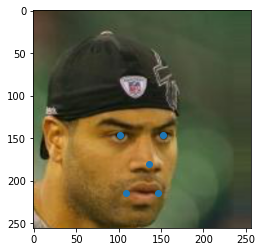

In [9]:
plt.scatter(celeba_dataset[5]['meta']['keypts'][:,0], \
            celeba_dataset[5]['meta']['keypts'][:,1])
plt.imshow(celeba_dataset[5]['data'].permute(1,2,0).numpy())


In [9]:
class UniformMeasure2D01(ProbabilityMeasure):

    def __init__(self, coord: Tensor):
        B, N, D = coord.shape
        assert D == 2
        assert coord.max() < 1 + 1e-8
        assert coord.min() > - 1e-8
        prob = torch.ones(B, N, device=coord.device, dtype=torch.float32) / N
        super().__init__(prob, coord)

In [8]:
image_size = 256
batch_size = 8
padding = 5

fabric = ProbabilityMeasureFabric(image_size)
barycenter: ProbabilityMeasure = fabric.random(padding).cuda()
barycenter.requires_grad_()

coord = barycenter.coord

opt = optim.Adam(iter([coord]), lr=0.0006)

In [4]:
mafl_dataloader = LazyLoader.mafl().loader_train_inf

In [15]:
!ls

barycenter_iod_value.ipynb	 __pycache__
barycenter_MAFL.ipynb		 stylegan_train.py
barycenter.py			 stylegan_train_unsupervised2.py
bez_ifovii_notebook.ipynb	 stylegan_train_unsupervised_bk.py
data.ipynb			 stylegan_train_unsupervised.py
dataparallel_module_check.ipynb  test.jpg
evalmodel.py			 test_transformed.jpg
face_segmentation.py		 unsupervised_otrisovka.ipynb
face_segm_regulazier_test.py	 Untitled.ipynb
face_segm_without_cond.py	 Untitleed.ipynb
gan_g_verka.py			 w300.ipynb
init_con_style.py		 w300_kp.py
__init__.py			 w300.py
munit_face_reg.py		 w300_stylegan_encoder.py
munit_face_reg_true_mask.py	 w300_stylegan.py
otrisovka.ipynb


0 0.001846797065809369


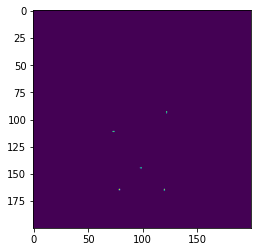

100 0.001383443595841527


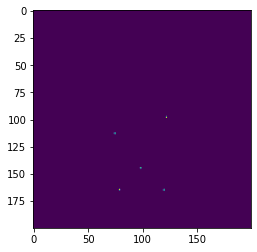

200 0.0010094244498759508


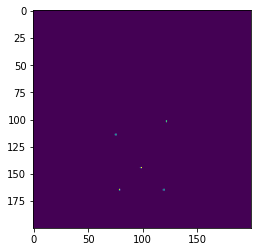

300 0.0007548790890723467


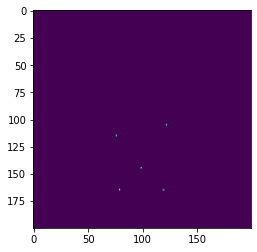

400 0.0007030956912785769


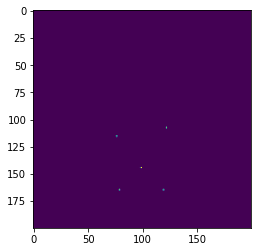

500 0.0006874111131764948


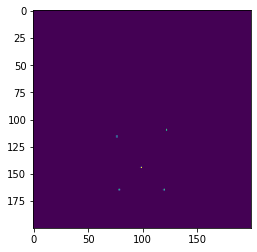

600 0.0004981410456821322


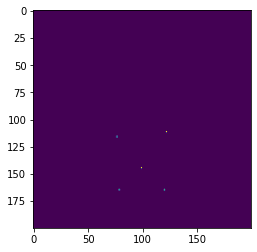

700 0.0004795687855221331


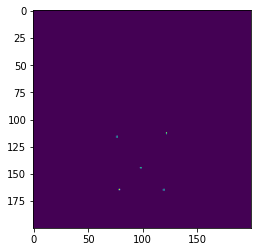

800 0.0005342424847185612


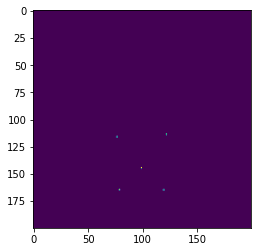

900 0.0008377080084756017


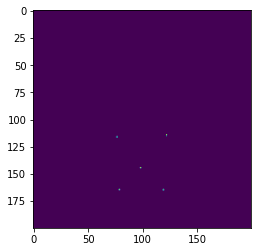

1000 0.0006234479369595647


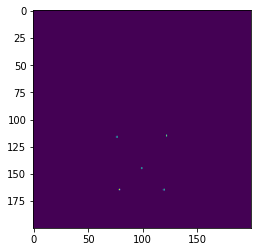

1100 0.0005111910868436098


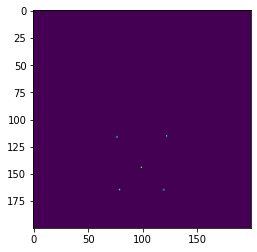

1200 0.0008264934876933694


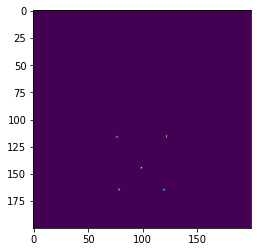

1300 0.0004796840948984027


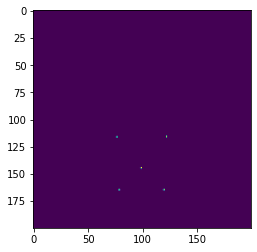

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

1400 0.0010677606333047152


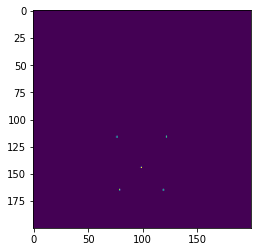

1500 0.0006424748571589589


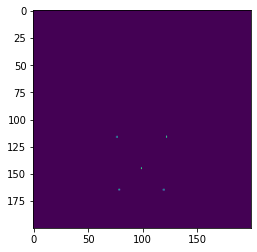

1600 0.0004616293008439243


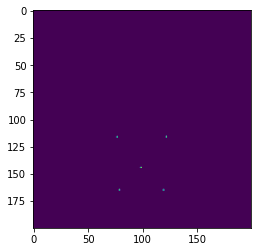

1700 0.0006978381425142288


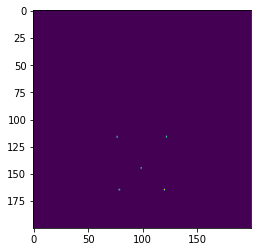

1800 0.0005355619359761477


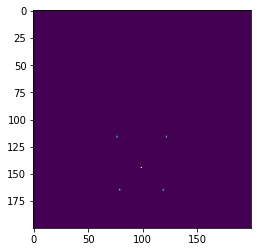

1900 0.0009821717394515872


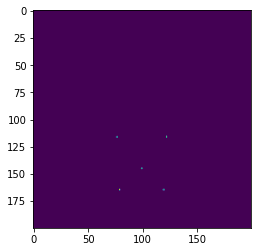

2000 0.0004995536291971803


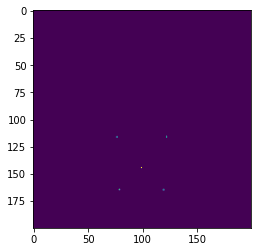

2100 0.0004284791648387909


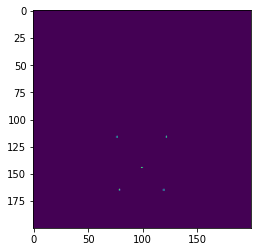

2200 0.0005180251901037991


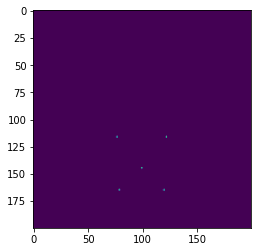

2300 0.0003586438251659274


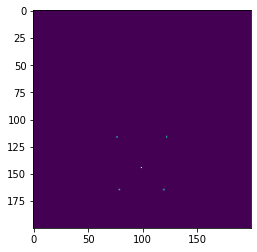

2400 0.000516256783157587


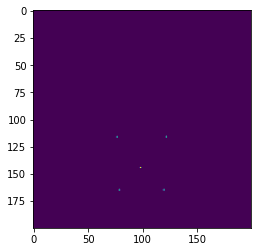

2500 0.00038872071309015155


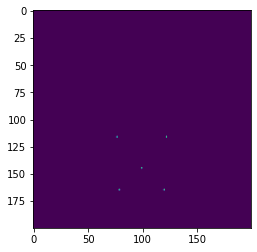

2600 0.0006127436645328999


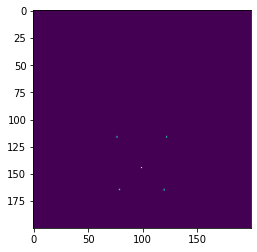

2700 0.0002867941511794925


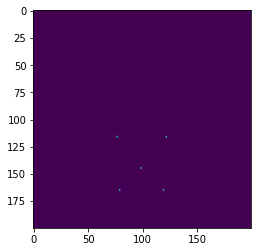

2800 0.00040820694994181395


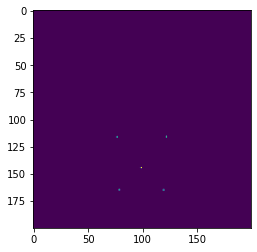

2900 0.00032196089159697294


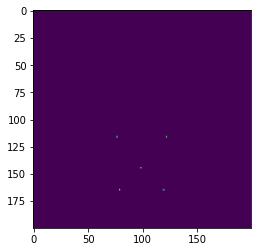

In [16]:
for iter in range(3000):
    mes = UniformMeasure2D01(next(mafl_dataloader)['meta']['keypts_normalized'].type(torch.float32)).cuda()
#     img = next(LazyLoader.celeba().loader).cuda()
#     content = encoder_HG(img)
#     coord, p = heatmap_to_measure(content)
#     mes = ProbabilityMeasure(p, coord)

    barycenter_cat = fabric.cat([barycenter] * batch_size)

    loss = Samples_Loss()(barycenter_cat, mes)

    opt.zero_grad()
    loss.to_tensor().backward()
    opt.step()

    barycenter.probability.data = barycenter.probability.relu().data
    barycenter.probability.data /= barycenter.probability.sum(dim=1, keepdim=True)

    if iter % 100 == 0:
        print(iter, loss.item())

        plt.imshow(barycenter.toImage(200)[0][0].detach().cpu().numpy())
        plt.show()

fabric.save("./face_barycenter_5", barycenter)

In [11]:
coord.shape

torch.Size([1, 5, 2])

In [ ]:
ToHeatMap

In [8]:
xes, yes = dataset_train[0]["meta"]["keypts"].numpy()[:,0], dataset_train[0]["meta"]["keypts"].numpy()[:,1]

In [15]:
kps = [Keypoint(x=xes[i], y=yes[i]) for i in range(len(xes))]
KeypointsOnImageee = KeypointsOnImage(kps, shape=(256,256))

In [16]:
KeypointsOnImageee

KeypointsOnImage([Keypoint(x=115.28089888, y=166.71428571), Keypoint(x=157.75280899, y=157.62244898), Keypoint(x=163.82022472, y=190.95918367), Keypoint(x=112.24719101, y=233.38775510), Keypoint(x=148.65168539, y=236.41836735)], shape=(256, 256))

In [32]:
dataset_train[15]['data'][None, ...].shape

torch.Size([1, 3, 256, 256])

In [35]:
dataset_train[15]['meta']['keypts']#[None, ...].shape

tensor([[101.6966, 140.6837],
        [153.2697, 142.1990],
        [133.5506, 175.5357],
        [110.7978, 207.3571],
        [145.6854, 207.3571]], dtype=torch.float64)

In [24]:
kek = g_transforms(image = dataset_train[0]['data'][None, ...])#, keypts = dataset_train[0]["meta"]["keypts"][None, ...])
print(kek['image'].shape)
print(kek.keys())

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:3688: error: (-215:Assertion failed) !dsize.empty() in function 'resize'
